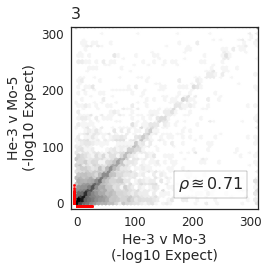

In [3]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import json as js
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import numpy.random as rng
import scipy.stats as stats
import scipy.special as scisp
import scipy.stats.mstats as mstats
import pandas as pd

# What does this do?
# Plot rank consistency of identified
# HSPs across replicate pairs

date = '20180720'

run_reprank_comparison = True

save_figures = True
diss_version = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'isect_raw_self')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
diss_out = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'
tex_file = os.path.join(base_out, 'supplement', 'supp_table_SX_repcorr.tex')

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')


def collect_replicate_overlap(ovl_folder, cache_file):
    
    header = ['chrom', 'start', 'end', 'name', 'nat_score', 'expect', 'pv', 'nat_lnorm', 's1', 's2']
    columns = ['A_' + h for h in header]
    columns += ['B_' + h for h in header]
    columns += ['overlap']
        
    for tsv in os.listdir(ovl_folder):
        if not tsv.endswith('.tsv'):
            continue
        tsv_path = os.path.join(ovl_folder, tsv)
        
        seg, _, c1, _, c2, scoring, _ = tsv.split('_')
        comp = c1 + '_vs_' + c2
                        
        ovl = pd.read_csv(tsv_path, sep='\t', skiprows=1, header=None,
                          names=columns, index_col=False)
        ovl, singletons = split_non_overlapping(ovl)
        
        # drop self-overlaps
        idx_self = np.logical_and(ovl['A_s1'] == ovl['B_s1'], ovl['A_s2'] == ovl['B_s2'])
        ovl = ovl.loc[~idx_self, ['A_s1', 'A_s2', 'A_name', 'A_expect',
                                  'B_s1', 'B_s2', 'B_name', 'B_expect', 'overlap']].copy()
        
        # reduce to replicate comparisons
        idx_rep = np.logical_or(ovl['A_s1'] == ovl['B_s1'], ovl['A_s2'] == ovl['B_s2'])
        ovl = ovl.loc[idx_rep, :].copy()
        
        ovl['A_pair'] = ovl['A_s1'] + '_vs_' + ovl['A_s2']
        ovl['B_pair'] = ovl['B_s1'] + '_vs_' + ovl['B_s2']
        ovl['rep_comp'] = ovl['A_pair'] + '_to_' + ovl['B_pair']
        
        stat_table = []
        
        for rc in ovl['rep_comp'].unique():
            sub = ovl.loc[ovl['rep_comp'] == rc, :]
            apair, bpair = rc.split('_to_')
            spr_rho, spr_pv = stats.spearmanr(sub['A_expect'], sub['B_expect'])
            
            a_unique = sub['A_name'].unique().size
            b_unique = sub['B_name'].unique().size
            
            a_nonhits = singletons.loc[singletons['pair'].isin(sub['A_pair']), 'name'].unique().size
            b_nonhits = singletons.loc[singletons['pair'].isin(sub['B_pair']), 'name'].unique().size
            
            a_miss_rate = np.round((a_nonhits / (a_unique + a_nonhits)) * 100, 2)
            b_miss_rate = np.round((b_nonhits / (b_unique + b_nonhits)) * 100, 2)
            
            stat_table.append((seg, scoring, c1, c2, np.round(spr_rho, 3), apair, bpair,
                               a_unique, b_unique, a_nonhits, b_nonhits,
                               a_miss_rate, b_miss_rate))

        stat_table = pd.DataFrame(stat_table,
                                  columns=['segmentation', 'scoring', 'cell1', 'cell2', 'spr_rho',
                                           'A_pair', 'B_pair', 'A_shared', 'B_shared',
                                           'A_unique', 'B_unique', 'A_miss_rate', 'B_miss_rate'])
        
        store_root = os.path.join(seg, scoring, comp)
        with pd.HDFStore(cache_file, 'a') as hdf:
            store_shared = os.path.join(store_root, 'shared')
            hdf.put(store_shared, ovl, format='fixed')
            store_uniq = os.path.join(store_root, 'unique')
            hdf.put(store_uniq, singletons, format='fixed')
            store_stats = os.path.join(store_root, 'stats')
            hdf.put(store_stats, stat_table, format='fixed')
            hdf.flush()

    return cache_file


def split_non_overlapping(segments):
    """
    """
    segments['unique_id'] = segments['A_name'] + '_from_' + segments['A_s1'] + '_vs_' + segments['A_s2']
    non_ovl = set()
    counter = col.Counter(segments['unique_id'])
    for n, c in reversed(counter.most_common()):
        if c > 1:
            break
        non_ovl.add(n)
    singletons = segments.loc[segments['unique_id'].isin(non_ovl), :].copy()
    singletons['name'] = singletons['A_name']
    singletons['expect'] = singletons['A_expect']
    singletons['pair'] = singletons['A_s1'] + '_vs_' + singletons['A_s2']
    singletons['s1'] = singletons['A_s1']
    singletons['s2'] = singletons['A_s2']
    singletons.drop(['unique_id', 'A_name', 'A_expect', 'A_s1', 'A_s2',
                     'B_s1', 'B_s2', 'B_name', 'B_expect'], axis=1, inplace=True)
    singletons['overlap'] = 0
    
    pre_shape = singletons.shape
    singletons.drop_duplicates(inplace=True)
    post_shape = singletons.shape
    assert pre_shape == post_shape, 'Singletons should only appear once'
    segments.drop(['unique_id'], axis=1, inplace=True)
    return segments, singletons
    

def plot_replicate_consistency(shared_hsp, unique_hsp, example, spr_rho, fk, save_diss):
    
    
    fig, ax = plt.subplots(figsize=fig_sizes['one_col']['square'])

    sub_plot = shared_hsp.loc[shared_hsp['rep_comp'] == example, :].copy()
        
    a_miss = unique_hsp.loc[unique_hsp['pair'].isin(sub_plot['A_pair']), :]
    b_miss = unique_hsp.loc[unique_hsp['pair'].isin(sub_plot['B_pair']), :]
    
    x_vals = sub_plot['A_expect'].values
    min_nonzero = x_vals[x_vals > 0].min()
    x_vals[x_vals == 0] = min_nonzero
    x_vals = -1 * np.log10(x_vals)
        
    y_vals = sub_plot['B_expect'].values
    min_nonzero = y_vals[y_vals > 0].min()
    y_vals[y_vals == 0] = min_nonzero
    y_vals = -1 * np.log10(y_vals)
       
    assert (a_miss['expect'] > 0).all(), 'Zero in A miss'
    assert (b_miss['expect'] > 0).all(), 'Zero in B miss'
    
    ax.hexbin(x_vals, y_vals, gridsize=50, bins='log', marginals=False,
              cmap='Greys')  #, label=r'$\rho\/\approxeq' + str(spr_rho) + '$')
    
    x_miss = -1 * np.log10(a_miss['expect'])
    y_miss = -1 * np.log10(b_miss['expect'])
        
    ax.scatter(x_miss, np.zeros_like(x_miss) - 5, marker='.',
               s=25, color='red', label=None)
    
    ax.scatter(np.zeros_like(y_miss) - 5, y_miss, marker='.',
               s=25, color='red', label=None)
    
    ax.set_xlim(-10, x_vals.max() + 1)
    ax.set_ylim(-10, y_vals.max() + 1)
    
    # Hf03_LiHe_Ct_vs_Hm03_BlMo_Ct_to_Hf03_LiHe_Ct_vs_Hm05_BlMo_Ct
    a_label, b_label = example.split('_to_')
    a_label = a_label[7:9] + '-' + a_label[3] + ' v ' + a_label[23:25] + '-' + a_label[19]
    b_label = b_label[7:9] + '-' + b_label[3] + ' v ' + b_label[23:25] + '-' + b_label[19]
    
    tickmarks = [0, 100, 200, 300]
    ax.set_xticks(tickmarks)
    ax.set_xticklabels(map(str, tickmarks), fontsize=12)
    ax.set_xlabel(a_label + '\n(-log10 Expect)', fontsize=14)
    
    ax.set_yticks(tickmarks)
    ax.set_yticklabels(map(str, tickmarks), fontsize=12)
    ax.set_ylabel(b_label + '\n(-log10 Expect)', fontsize=14)
    
    ax.text(175, 25, s=r'$\rho\/\approxeq\/' + str(spr_rho) + '$',
            fontdict={'fontsize': 16},
            bbox={'facecolor': 'white', 'alpha': 0.7})
    
    if not save_diss:
        tt = ax.set_title(fk, fontsize=16)
        tt.set_position((0.025, 1.01))
    return fig, []
    
    
def tabulate_statistics(seg, score, cache_file, tex_output):
    
    stat_data = []
    with pd.HDFStore(cache_file, 'r') as hdf:
        stat_keys = [k for k in hdf.keys() if k.endswith('/stats')]
        load_keys = [k for k in stat_keys if seg in k and score in k]
        for k in load_keys:
            comp = k.split('/')[-2]
            if comp == 'Liver_vs_Blood':
                continue
            stat_data.append(hdf[k])
    stat_data = pd.concat(stat_data, axis=0, ignore_index=False, sort=False)
    #print(stat_data.loc[stat_data['A_pair'] ==  'Hf03_LiHe_Ct_vs_Hm03_BlMo_Ct', :])
    avg_miss = stat_data.groupby(['cell1', 'cell2'], as_index=True)['A_miss_rate', 'B_miss_rate'].mean()
    avg_miss.drop(['B_miss_rate'], axis=1, inplace=True)
    std_miss = stat_data.groupby(['cell1', 'cell2'], as_index=True)['A_miss_rate', 'B_miss_rate'].std()
    std_miss.drop(['B_miss_rate'], axis=1, inplace=True)
    avg_corr = stat_data.groupby(['cell1', 'cell2'], as_index=True)['spr_rho'].mean()
    std_corr = stat_data.groupby(['cell1', 'cell2'], as_index=True)['spr_rho'].std()
    std_corr.index.Name = 'rho_std'
    
    stat_table = pd.concat([avg_corr, std_corr, avg_miss, std_miss], axis=1, ignore_index=False)
    stat_table.columns = ['spr_rho', 'rho_std', 'miss_rate', 'miss_std']
    stat_table = stat_table.round(2)
    
    tex_corr = stat_table['spr_rho'].astype(str) + ' (' + stat_table['rho_std'].astype(str) + ')'
    tex_miss = stat_table['miss_rate'].astype(str) + ' (' + stat_table['miss_std'].astype(str) + ')'
    
    tex_table = pd.concat([tex_corr, tex_miss], axis=1, ignore_index=False)
    tex_table.reset_index(drop=False, inplace=True)
    tex_table.columns = ['group1', 'group2', 'rho', 'missrate']
    tex_table.to_latex(tex_output, bold_rows=True, column_format='ccll',
                       encoding='ascii', index_names=False, header=True, index=False)
    return None
    
    
    

if run_reprank_comparison:
    cache_file = os.path.join(cache_dir, '{}_plot_reprank_comparison.h5'.format(date))
    if not os.path.isfile(cache_file):
        cache_file = collect_replicate_overlap(isect_root, cache_file)
    
    # selection based on median correlation
    # i.e., this comparison is representative
    plot_comparison = 'Hf03_LiHe_Ct_vs_Hm03_BlMo_Ct_to_Hf03_LiHe_Ct_vs_Hm05_BlMo_Ct'
    rho = 0.71
    comp = 'He_vs_Mo'
    
    for seg in segmentations:
        if seg != 'cmm18':
            continue
        for score in scorings:
            if score != 'penem':
                continue
            _ = tabulate_statistics(seg, score, cache_file, tex_file)
            hits, misses = None, None
            with pd.HDFStore(cache_file, 'r') as hdf:
                for k in hdf.keys():
                    if seg in k and score in k and comp in k:
                        if k.endswith('shared'):
                            hits = hdf[k]
                        elif k.endswith('unique'):
                            misses = hdf[k]
                        else:
                            continue
            assert hits is not None, 'Hits misssed'
            assert misses is not None, 'Misses not hit'
            fkey = '3'
            fig, exart = plot_replicate_consistency(hits, misses, plot_comparison, rho, fkey, diss_version)
                        
            if save_figures:
                outname = 'fig_{}_ex_repcons_{}_{}'.format(fkey, seg, score)
                if diss_version:
                    outfolder = diss_out
                else:
                    outfolder = fig_main
                
                outpath = os.path.join(outfolder, outname + '.pdf')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                
                if not diss_version:
                    outpath = os.path.join(outfolder, outname + '.png')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=resolution[res]) 
